# Amazon Reviews of Beauty Products: 

## Sentiment Analysis, Topic Modelling, and Classification of Reviews by Rating

### Dataset from http://jmcauley.ucsd.edu/data/amazon/ 

> ### 198,502 Amazon ratings and reviews from May 1996 - July 2014.

In [157]:
import pandas as pd
import numpy as np
import gzip
import re
import string
from string import digits
from textblob import TextBlob
import seaborn as ssn
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from textblob.classifiers import NaiveBayesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from statsmodels.graphics.correlation import plot_corr
from sklearn.grid_search import GridSearchCV

/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def show_confusion_matrix(C,class_labels=['0','1']):
    #From text classification solutions
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Beauty_5.json.gz')

## EDA / Data Preprocessing

In [6]:
df.reviewText = df.reviewText.str.lower() #lowercase
df['reviewText_clean'] = df['reviewText'].apply(lambda x:''.join([i for i in x 
                                                  if i not in string.punctuation])) #remove punctuation
remove_digits = str.maketrans('', '', digits)
df['reviewText_clean'] = df['reviewText_clean'].apply(lambda x: x.translate(remove_digits)) #remove digits

In [7]:
df['helpful_rate'] = [0 if i[1] == 0 else i[0]/i[1] for i in df.helpful]

In [8]:
df.head()

,reviewTime,reviewerID,overall,asin,summary,unixReviewTime,reviewText,helpful,reviewerName,reviewText_clean,helpful_rate
0,"01 30, 2014",A1YJEY40YUW4SE,1.0,7806397051,Don't waste your money,1391040000,very oily and creamy. not at all what i expect...,"[3, 4]",Andrea,very oily and creamy not at all what i expecte...,0.75
1,"04 18, 2014",A60XNB876KYML,3.0,7806397051,OK Palette!,1397779200,this palette was a decent price and i was look...,"[1, 1]",Jessica H.,this palette was a decent price and i was look...,1.00
2,"09 6, 2013",A3G6XNM240RMWA,4.0,7806397051,great quality,1378425600,the texture of this concealer pallet is fantas...,"[0, 1]",Karen,the texture of this concealer pallet is fantas...,0.00
3,"12 8, 2013",A1PQFP6SAJ6D80,2.0,7806397051,Do not work on my face,1386460800,i really can't tell what exactly this thing is...,"[2, 2]",Norah,i really cant tell what exactly this thing is ...,1.00
4,"10 19, 2013",A38FVHZTNQ271F,3.0,7806397051,It's okay.,1382140800,"it was a little smaller than i expected, but t...","[0, 0]",Nova Amor,it was a little smaller than i expected but th...,0.00


In [95]:
df["review_length"] = [len(i) for i in df.reviewText_clean]

/Users/helloaoi/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


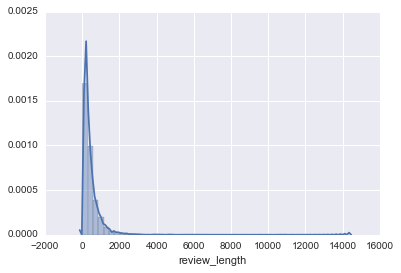

In [118]:
ssn.distplot(df[df.overall == 1.0]["review_length"])

/Users/helloaoi/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


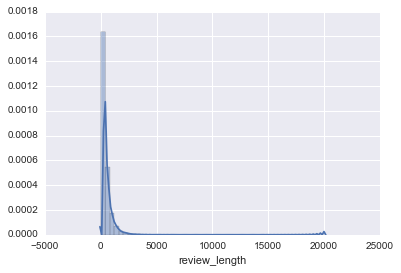

In [117]:
ssn.distplot(df[df.overall == 5.0]["review_length"]);

/Users/helloaoi/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


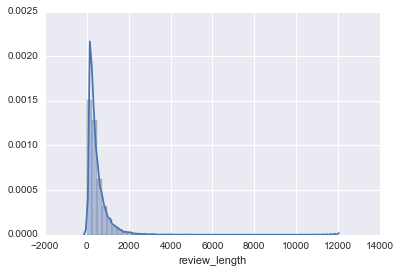

In [119]:
ssn.distplot(df[df.overall == 2.0]["review_length"])

/Users/helloaoi/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


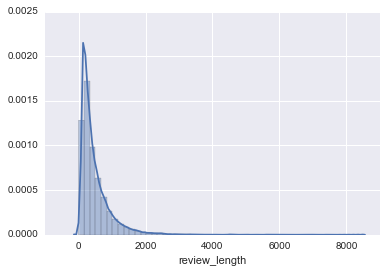

In [115]:
ssn.distplot(df[df.overall == 3.0]["review_length"])

/Users/helloaoi/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


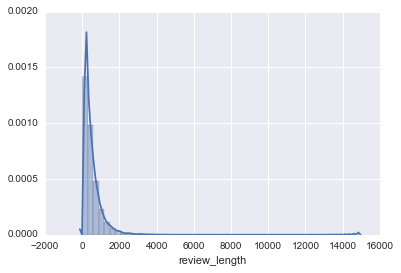

In [120]:
ssn.distplot(df[df.overall == 4.0]["review_length"])

In [101]:
print("Mean length of reviews:", df.review_length.mean())
print("Median length of reviews:", df.review_length.median())

Mean length of reviews: 456.3419713655278
Median length of reviews: 299.0


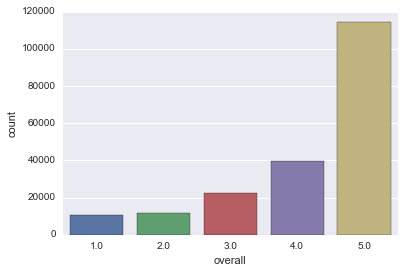

In [9]:
ssn.countplot(df.overall)

# Sentiment Analysis

In [10]:
df['sentiment_labels'] = [1 if rating >= 4 else 0 for rating in df.overall]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df.reviewText_clean,df.sentiment_labels, test_size=.2, random_state=42)

## CountVectorizer + Multinomial Naive Bayes 

In [134]:
count_vec = CountVectorizer()
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

In [135]:
# Create an instance of the Naive Bayes class 
clf = MultinomialNB()
# Call fit method
clf.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
precision = precision_score(y_true=y_test,
              y_pred=clf.predict(X_test_count))

print("Multinomial NB: The precision on the test data is {:.2%}".format(precision))
recall = recall_score(y_true=y_test,
                      y_pred=clf.predict(X_test_count))

print("Multinomial NB: The recall on the test data is {:.2%}".format(recall))
f1 = f1_score(y_true=y_test,
              y_pred=clf.predict(X_test_count))
print("Multinomial NB: The F1 on the test data is {:.2%}".format(f1))

Multinomial NB: The precision on the test data is 87.08%
Multinomial NB: The recall on the test data is 95.08%
Multinomial NB: The F1 on the test data is 90.91%


In [15]:
cm_train = confusion_matrix(y_train, clf.predict(X_train_count))

In [16]:
cm_test = confusion_matrix(y_test, clf.predict(X_test_count))

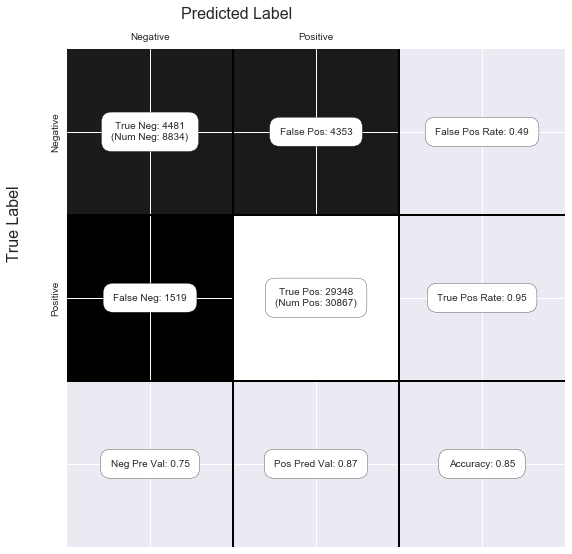

In [17]:
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

## Tf-idf + Multinomial Naive Bayes

In [190]:
tfidf_vec = TfidfVectorizer(stop_words='english')
X_train_count = tfidf_vec.fit_transform(X_train)
X_test_count = tfidf_vec.transform(X_test)

In [19]:
clf2 = MultinomialNB()
clf2.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
precision = precision_score(y_true=y_test,
              y_pred=clf2.predict(X_test_count))

print("Multinomial NB: The precision on the test data is {:.2%}".format(precision))
recall = recall_score(y_true=y_test,
                      y_pred=clf2.predict(X_test_count))

print("Multinomial NB: The recall on the test data is {:.2%}".format(recall))
f1 = f1_score(y_true=y_test,
              y_pred=clf2.predict(X_test_count))
print("Multinomial NB: The F1 on the test data is {:.2%}".format(f1))

Multinomial NB: The precision on the test data is 77.88%
Multinomial NB: The recall on the test data is 99.96%
Multinomial NB: The F1 on the test data is 87.55%


In [21]:
cm_train = confusion_matrix(y_train, clf2.predict(X_train_count))
cm_test = confusion_matrix(y_test, clf2.predict(X_test_count))

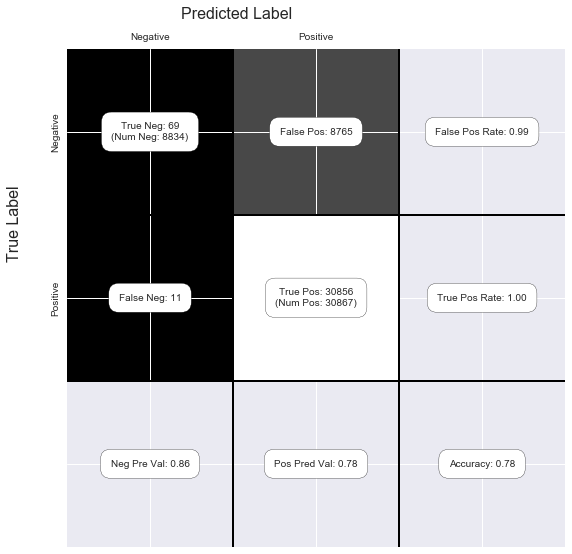

In [22]:
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

> ### CountVectorizer yielded better 10% better precision and a 3% better F1 score. Maybe there are key words that appear frequently across all reviews that are useful in predicting sentiment.

## Sentiment Analysis Logistic Regression

In [191]:
lr1 = LogisticRegression(penalty='l1')
lr2 = LogisticRegression(penalty='l2')

In [192]:
lr1.fit_transform(X_train_count, y_train)

/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<158801x5494 sparse matrix of type '<class 'numpy.float64'>'
	with 4624550 stored elements in Compressed Sparse Column format>

In [193]:
lr2.fit_transform(X_train_count, y_train)

/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<158801x41209 sparse matrix of type '<class 'numpy.float64'>'
	with 5056719 stored elements in Compressed Sparse Column format>

# Lasso Regularized

In [26]:
print("The precision score is {}".format(precision_score(y_test, lr1.predict(X_test_count))))
print("The recall score is {}".format(recall_score(y_test, lr1.predict(X_test_count))))
print("The f1 score is {}".format(f1_score(y_test, lr1.predict(X_test_count))))

The precision score is 0.8846733819892635
The recall score is 0.9503353095538926
The f1 score is 0.916329558766107


In [27]:
cm_test = confusion_matrix(y_test, lr1.predict(X_test_count))

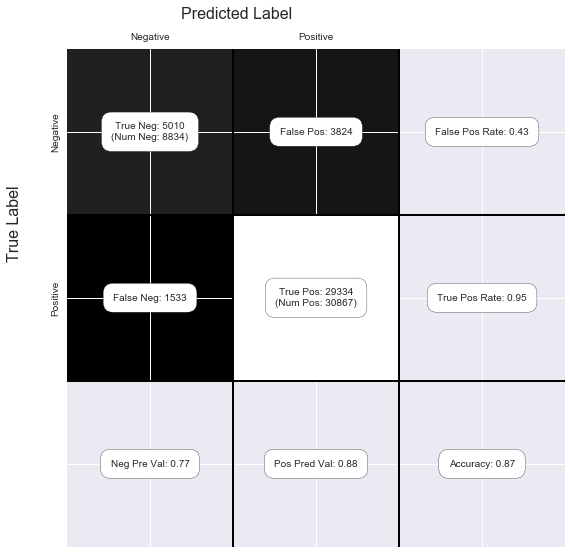

In [28]:
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

# Ridge Regularized

In [30]:
print("The precision score is {}".format(precision_score(y_test, lr2.predict(X_test_count))))
print("The recall score is {}".format(recall_score(y_test, lr2.predict(X_test_count))))
print("The f1 score is {}".format(f1_score(y_test, lr2.predict(X_test_count))))

The precision score is 0.8819762396385074
The recall score is 0.9548385006641397
The f1 score is 0.9169622301039139


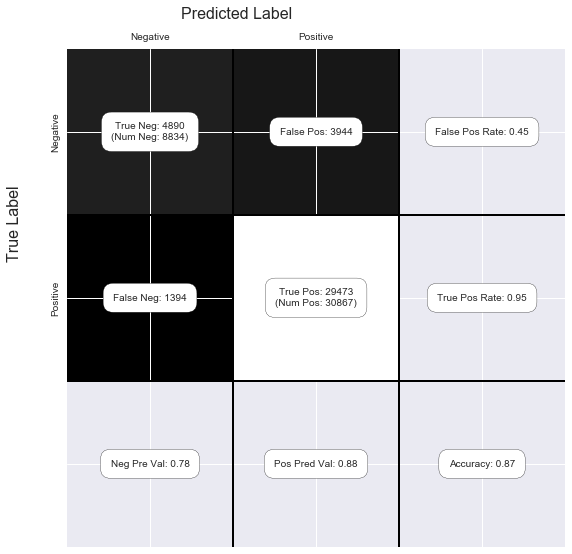

In [31]:
cm_test = confusion_matrix(y_test, lr2.predict(X_test_count))
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

>Logistic Regression performed just as well as Naive Bayes!

## TextBlob NaiveBayes Sentiment Analysis

In [32]:
from textblob.classifiers import NaiveBayesClassifier

In [33]:
df['sentiment_score'] = [TextBlob(i).sentiment.polarity for i in df.reviewText_clean]
df['sentiment_score'] = [ 1 if sentiment > 0 else 0 for sentiment in df.sentiment_score]

In [34]:
X_test_polarity = [TextBlob(text).sentiment.polarity for text in X_test]
y_pred = np.asarray([ 1 if polarity > 0 else 0 for polarity in X_test_polarity] )


In [35]:
print("The precision score is {}".format(precision_score(y_test, y_pred)))
print("The recall score is {}".format(recall_score(y_test, y_pred)))
print("The f1 score is {}".format(f1_score(y_test, y_pred)))

The precision score is 0.8156322227859518
The recall score is 0.937473677390093
The f1 score is 0.8723189388800964


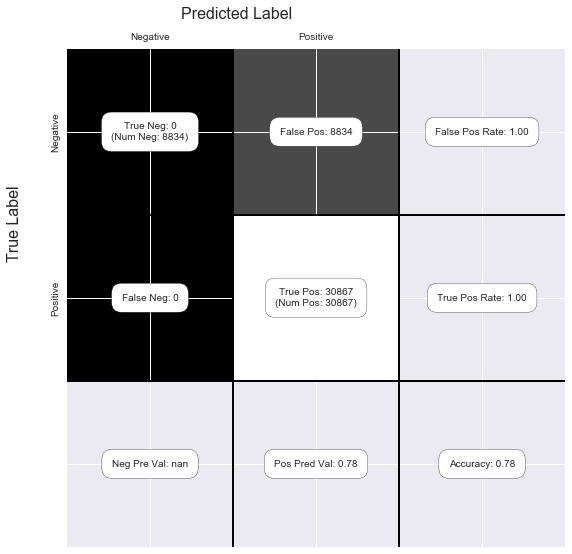

In [40]:
cm_test = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

## Let's take a look at 5 star reviews with negative sentiment

In [132]:
df[df.overall == 5.0][df.sentiment_score == 0]["reviewText"][346]

/Users/helloaoi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


"i don't really like the smell of this... at all. actually its horrible but it is the one thing that will help scalp build up or dandruff almost immediately so its worth the nasty smell."

## Analysis on helpful reviews

In [41]:
helpful_reviews = df[df.helpful_rate > 0.5]

In [42]:
helpful_reviews

,reviewTime,reviewerID,overall,asin,summary,unixReviewTime,reviewText,helpful,reviewerName,reviewText_clean,helpful_rate,sentiment_labels,sentiment_score
0,"01 30, 2014",A1YJEY40YUW4SE,1.0,7806397051,Don't waste your money,1391040000,very oily and creamy. not at all what i expect...,"[3, 4]",Andrea,very oily and creamy not at all what i expecte...,0.750000,0,0
1,"04 18, 2014",A60XNB876KYML,3.0,7806397051,OK Palette!,1397779200,this palette was a decent price and i was look...,"[1, 1]",Jessica H.,this palette was a decent price and i was look...,1.000000,0,1
3,"12 8, 2013",A1PQFP6SAJ6D80,2.0,7806397051,Do not work on my face,1386460800,i really can't tell what exactly this thing is...,"[2, 2]",Norah,i really cant tell what exactly this thing is ...,1.000000,0,1
19,"09 19, 2011",A1QV5IH6HDRN0L,5.0,9788072216,Love the smell of this!,1316390400,i haven't been a big fan of prada's fragrances...,"[24, 24]",armygirl,i havent been a big fan of pradas fragrances o...,1.000000,1,1
21,"11 28, 2011",A2EK2CJNJUF7OQ,5.0,9788072216,Very good,1322438400,this is the first fragrance by prada that i lo...,"[1, 1]",Nikki,this is the first fragrance by prada that i lo...,1.000000,1,1
24,"03 11, 2014",A2FQZKL2KIZACO,5.0,9790790961,Spring Garden in a Bottle,1394496000,i'm very picky when it comes to fragrance. i l...,"[1, 1]",Ellie B.,im very picky when it comes to fragrance i lov...,1.000000,1,1
37,"03 22, 2014",A16NAH39LN211W,5.0,B00004TMFE,Really good stuff,1395446400,my hair is fine like a baby's and rather thin....,"[2, 3]",Blondie,my hair is fine like a babys and rather thin ...,0.666667,1,1
42,"09 13, 2013",A2EVBQAN92IEZS,1.0,B00004TMFE,Doesn't live up to its promises,1379030400,rather than leaving my hair softer and more ma...,"[3, 3]",Fati1981,rather than leaving my hair softer and more ma...,1.000000,0,1
46,"03 14, 2011",AX1567KGMAVLT,5.0,B00004TMFE,very surprised how much I love this,1300060800,"with the inevitable hormonal changes, my hair ...","[7, 8]",jjjjordan,with the inevitable hormonal changes my hair s...,0.875000,1,1
47,"06 8, 2013",AQX8T9SFFK43U,4.0,B00004TMFE,Losing less hair! See detailed review.,1370649600,"6/8/2013, first review: i thought to review th...","[3, 4]",Kristina Montes,first review i thought to review this product...,0.750000,1,1


In [43]:
X_train, X_test, y_train, y_test = train_test_split(helpful_reviews.reviewText_clean,helpful_reviews.sentiment_labels, test_size=.2, random_state=42)

# Multinomial NB + CountVectorizer (helpful reviews)

In [44]:
count_vec = CountVectorizer()
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

In [45]:
# Create an instance of the Naive Bayes class 
clf_helpful = MultinomialNB()
# Call fit method
clf_helpful.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
precision = precision_score(y_true=y_test,
              y_pred=clf_helpful.predict(X_test_count))

print("Multinomial NB: The precision on the test data is {:.2%}".format(precision))
recall = recall_score(y_true=y_test,
                      y_pred=clf_helpful.predict(X_test_count))

print("Multinomial NB: The recall on the test data is {:.2%}".format(recall))
f1 = f1_score(y_true=y_test,
              y_pred=clf_helpful.predict(X_test_count))
print("Multinomial NB: The F1 on the test data is {:.2%}".format(f1))

Multinomial NB: The precision on the test data is 84.46%
Multinomial NB: The recall on the test data is 97.39%
Multinomial NB: The F1 on the test data is 90.47%


> Scores on all-reviews: 

> Multinomial NB: The precision on the test data is 87.08%

> Multinomial NB: The recall on the test data is 95.08%

> Multinomial NB: The F1 on the test data is 90.91%

# Multinomial NB + tf-idf (helpful reviews)

In [47]:
tfidf_vec = TfidfVectorizer(stop_words='english')
X_train_count = tfidf_vec.fit_transform(X_train)
X_test_count = tfidf_vec.transform(X_test)

In [48]:
clf_helpful_tfidf = MultinomialNB()
clf_helpful_tfidf.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
precision = precision_score(y_true=y_test,
              y_pred=clf_helpful_tfidf.predict(X_test_count))

print("Multinomial NB: The precision on the test data is {:.2%}".format(precision))
recall = recall_score(y_true=y_test,
                      y_pred=clf_helpful_tfidf.predict(X_test_count))

print("Multinomial NB: The recall on the test data is {:.2%}".format(recall))
f1 = f1_score(y_true=y_test,
              y_pred=clf_helpful_tfidf.predict(X_test_count))
print("Multinomial NB: The F1 on the test data is {:.2%}".format(f1))

Multinomial NB: The precision on the test data is 78.42%
Multinomial NB: The recall on the test data is 99.99%
Multinomial NB: The F1 on the test data is 87.90%


In [50]:
lr1_helpful = LogisticRegression(penalty='l1')
lr2_helpful = LogisticRegression(penalty='l2')

In [51]:
lr1.fit_transform(X_train_count, y_train)

/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<47152x1448 sparse matrix of type '<class 'numpy.float64'>'
	with 1200572 stored elements in Compressed Sparse Column format>

In [52]:
lr2.fit_transform(X_train_count, y_train)

/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<47152x21872 sparse matrix of type '<class 'numpy.float64'>'
	with 1731839 stored elements in Compressed Sparse Column format>

# Lasso Regression (helpful reviews)

In [53]:
print("The precision score is {}".format(precision_score(y_test, lr1.predict(X_test_count))))
print("The recall score is {}".format(recall_score(y_test, lr1.predict(X_test_count))))
print("The f1 score is {}".format(f1_score(y_test, lr1.predict(X_test_count))))

The precision score is 0.8773519163763066
The recall score is 0.9534783079086877
The f1 score is 0.913832434674409


# Ridge Regression (helpful reviews)

In [54]:
print("The precision score is {}".format(precision_score(y_test, lr2.predict(X_test_count))))
print("The recall score is {}".format(recall_score(y_test, lr2.predict(X_test_count))))
print("The f1 score is {}".format(f1_score(y_test, lr2.predict(X_test_count))))

The precision score is 0.8704065676309617
The recall score is 0.9635399761982041
The f1 score is 0.9146084724005135


# TextBlob Sentiment Analysis NB (helpful reviews)

In [55]:
helpful_reviews['sentiment_score'] = [TextBlob(i).sentiment.polarity for i in helpful_reviews.reviewText_clean]
helpful_reviews['sentiment_score'] = [ 1 if sentiment > 0 else 0 for sentiment in helpful_reviews.sentiment_score]

/Users/helloaoi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/helloaoi/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [56]:
X_test_polarity = [TextBlob(text).sentiment.polarity for text in X_test]
y_pred = np.asarray([ 1 if polarity > 0 else 0 for polarity in X_test_polarity] )

In [57]:
print("The precision score is {}".format(precision_score(y_test, y_pred)))
print("The recall score is {}".format(recall_score(y_test, y_pred)))
print("The f1 score is {}".format(f1_score(y_test, y_pred)))

The precision score is 0.8195204832924297
The recall score is 0.9393054203180785
The f1 score is 0.8753339718707467


In [58]:
train = zip(X_train, y_train)

In [59]:
tbnb = NaiveBayesClassifier(train)

In [60]:
y_pred = [tbnb.classify(review) for review in X_test]

In [61]:
print("The precision score is {}".format(precision_score(y_test, y_pred)))
print("The recall score is {}".format(recall_score(y_test, y_pred)))
print("The f1 score is {}".format(f1_score(y_test, y_pred)))

The precision score is 0.784035965730766
The recall score is 1.0
The f1 score is 0.8789463674400914


>Sentiment analysis on helpful reviews data yields slightly more precision than sentiment analysis on all data.

## Topic Modelling

In [140]:
vectorizer = TfidfVectorizer(stop_words='english')

tfidf = vectorizer.fit_transform(df.reviewText_clean)

lda = LatentDirichletAllocation(n_topics=15,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)
lda.fit(tfidf)

def print_top_words(model, feature_names, n_top_words=20):
    for topic_n, topic in enumerate(model.components_, 1):
        print("Topic #{}:".format(topic_n))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

print("Topics in LDA model:")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names)

Topics in LDA model:
Topic #1:
gems hydralight blendable sculpting regrets sauve seventh resealable duration worki digging scheduled easter preserving sweetness sable needling craving ysl allday
Topic #2:
hair product skin like use great love really good just using color used face nice does dont shampoo dry little
Topic #3:
stones smokey blossom extract sodium biased seed ingredients glycol hrs chloride phytoceramides glycerin toni ginseng dimethicone unilever alcohol edta tester
Topic #4:
colours ot productas pealing curlswaves shortterm instructional values da againit pleases plusthe arises wispies perfecter pa aswell rio lola moistens
Topic #5:
studs evaluation alpine vinylux flowing pumping massager prepare newbie seas freely flows balding quilted rules builtin songs dresses doesi attaches
Topic #6:
snaps cards spouse ftc accordance cfr turnoff scrapbooking lotionlike marbling endorsement station prodcut calmer iteam dads dudes circumference thingsi ahold
Topic #7:
creations settli

# Useful Topics

Topic 2 = Colors:
color colors love designs pink great like polish looks beautiful pretty look nail dark nice $\textbf{shade}$ really $\textbf{glitter}$ red perfect

Topic 13 = Scents:
cute perfume ok scent scents $\textbf{cologne}$ def sponges $\textbf{unique fragrance}$ towelettes ur smelled spraying $\textbf{harmony}$ smell perfumes smelling lil holo

Topic 11 = Eyelashes/Eyebrows:
lashes $\textbf{mascara}$ wig eyelashes glue lash eyeshadow look eyelash eyes mascaras brows $\textbf{waterproof clump}$ clients false fake eyelids natural eye

Topic 15 - Nails:
nail nails polish coat great love gel use easy just product works good price really time like doing work colors

Topic 6 = Hair Styling:
hair use iron product great like brush flat conditioner plates really just $\textbf{hold curly}$ dry long dryer curls fine good

Topic 14 = Hair Treatment:
hair shampoo conditioner scalp shampoos suave $\textbf{dandruff conditioners}$ manageable soft leaves lather leave color $\textbf{condition clean}$ damaged antidandruff left treated

Topic 7 = Shipping:
product price money order great shipping buy got ordered good happy $\textbf{fast}$ love work came purchase seller $\textbf{arrived}$ worth just

Topic 8 = Packaging:
$\textbf{bag fits travel}$ purse size caress fit sun pouch carry $\textbf{lightweight}$ burts bees bags sealed smaller containers whip providing win

> This is useful to find what topics the consumers are interested in and the different segments of the beauty market, and it also can find buzzwords to help developing and advertising future products.

# Classification of Reviews by Rating

## Linear Regression of Rating with tf-idf

In [196]:
X_train, X_test, y_train, y_test = train_test_split(df.reviewText_clean,df.overall, test_size=.2, random_state=42)

In [197]:
X_train_count = tfidf_vec.fit_transform(X_train)
X_test_count = tfidf_vec.transform(X_test)

In [160]:
linreg = LinearRegression()

In [161]:
linreg.fit(X_train_count, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:
y_pred = np.rint(linreg.predict(X_test_count))

In [180]:
print("The precision score is {}".format(precision_score(y_test, y_pred, average=None)))
print("The recall score is {}".format(recall_score(y_test, y_pred, average=None)))
print("The f1 score is {}".format(f1_score(y_test, y_pred, average =None)))

The precision score is 0.5087612356114667
The recall score is 0.5771643031661671
The f1 score is 0.4228795997635898


/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes Text Classification by Rating with tf-idf

In [198]:
clf3 = MultinomialNB()
clf3.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [199]:
y_pred = clf3.predict(X_test_count)

In [187]:
cross_val_score(clf3, X_test_count, y_test, cv=5).mean()

0.57691244459947444

In [175]:
print("The precision score is {}".format(precision_score(y_test, y_pred, average=None)))
print("The recall score is {}".format(recall_score(y_test, y_pred, average=None)))
print("The f1 score is {}".format(f1_score(y_test, y_pred, average =None)))

The precision score is 0.5562676469422954
The recall score is 0.41558147149945845
The f1 score is 0.4564243137243268


/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/helloaoi/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [1]:
cm_test = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

NameError: name 'confusion_matrix' is not defined